# Evaluating SecBench
To demonstrate how our tool can utilize an existing dataset, we will first consider SecBench.

We read the CSV as a dataframe and limit the scope to 2016.

In [1]:
import pandas as pd
sb = pd.read_csv('../secbench.csv')
single_year = sb[(sb['year'] == 2016)]
single_year.dropna()
single_year

,owner,project,sha,sha-p,year,language,cve_id,cwe_id,score,severity
19,curl,curl,0796a993171f627d546c42a8fb28e906528cc688,2497c42172307485fb60100474b68c1620041df5,2016,c,NaN,CWE-401,NaN,NaN
20,php,php-src,082aecfc3a753ad03be82cf14f03ac065723ec92,d650063a0457aec56364e4005a636dc6c401f9cd,2016,c,CVE-2016-4542,CWE-119,7.5,HIGH
21,Pylons,pyramid,082d3b2cb9127f8acfd4d081e69c427a37bae91d,a6db36c984bd69f8a6aba80ad6db435cd4b1b93c,2016,py,NaN,CWE-208,NaN,NaN
49,mantisbt,mantisbt,11ab3d6c82a1d3a89b1024f77349fb60a83743c5,ecd12610576e71764a318d8ead1c753ab7a30d16,2016,php,CVE-2016-5364,CWE-79,4.3,MEDIUM
82,openssl,openssl,1fb9fdc3027b27d8eb6a1e6a846435b070980770,ac9fc67a488427bc3e987f5a4c235e8fbeedf711,2016,c,CVE-2016-2181,CWE-189,5.0,MEDIUM
...,...,...,...,...,...,...,...,...,...,...
658,WordPress,WordPress,f8e7680cd61652b16d30948968adafe0d4dcdd54,02424959e4dbbbf3c989c6d36f5807b6bb3ad7d8,2016,php,NaN,CWE-208,NaN,NaN
660,openssl,openssl,f962541d0be200055e508641ddf3a8ec8819e4df,bf52165bda53524a267c784696bd074111a2f178,2016,c,CVE-2016-7053,CWE-476,5.0,MEDIUM
666,torvalds,linux,fc878efe84c342441706fcdf776e08fe455fe9c1,9f0df936b1b93a7fab5b9ed73009f43369c121ea,2016,c,NaN,CWE-404,NaN,NaN
667,postgres,postgres,fcd15f13581f6d75c63d213220d5a94889206c1b,41f18f021a0882eccbeca62e2ed4b66c6b96e9c9,2016,c,CVE-2016-5424,CWE-94,4.6,MEDIUM


What we find is that there are 23 CWE categories represented and that some categories do not have an associated CVE entry.

In [2]:
single_year = single_year.dropna(subset=['cwe_id'])
cve_count_per_cwe = single_year.groupby('cwe_id')['cve_id'].count().reset_index(name='cve_count')
cve_count_per_cwe

,cwe_id,cve_count
0,CWE-119,5
1,CWE-189,4
2,CWE-190,1
3,CWE-20,5
4,CWE-200,3
5,CWE-208,0
6,CWE-284,2
7,CWE-352,0
8,CWE-399,5
9,CWE-400,1


# Evaluating the coverage of Secbench for 2016
Now that we can see the CWE categories represented in secbench in 2016, we will compare that to the distribution of CVEs into CWE categories for that year.

This will involve getting a count of the CVEs 

In [3]:
import sqlite3
import pandas as pd

# Connect to your SQLite database
conn = sqlite3.connect('../data/cwei.db')

# Define the SQL query
query = '''
SELECT
    cwe.cwe_id,
    COUNT(*) AS cve_count
FROM
    cve c
JOIN
    cve_cwe cc ON c.id = cc.cve_id
JOIN
    cwe ON cc.cwe_id = cwe.cwe_id
WHERE strftime('%Y', c.published_date) = '2016'
GROUP BY cwe.cwe_id
ORDER BY cve_count DESC;
'''

df = pd.read_sql_query(query, conn)
conn.close()

# Display the filtered DataFrame
df[:10]
df['rank'] = df['cve_count'].rank(method='first', ascending=False)

df['cwe_id'] = 'CWE-' + df['cwe_id'].astype(str)

In [4]:
df

,cwe_id,cve_count,rank
0,CWE-119,1031,1.0
1,CWE-200,684,2.0
2,CWE-20,525,3.0
3,CWE-79,472,4.0
4,CWE-284,396,5.0
...,...,...,...
76,CWE-306,1,77.0
77,CWE-297,1,78.0
78,CWE-203,1,79.0
79,CWE-193,1,80.0


In [5]:
# Step 1: Clean up 'cwe_id' in single_year dataframe
# single_year.loc[:, 'cwe_id'] = single_year['cwe_id'].str.replace('CWE-', '', regex=False)

# Step 2: Extract unique CWEs from both dataframes
cwe_ids_single_year = single_year['cwe_id'].dropna().unique()  # CWEs from single_year
cwe_ids_df = df['cwe_id'].dropna().unique()  # CWEs from df


# Step 3: Find common CWEs between the two dataframes
common_cwes = set(cwe_ids_single_year).intersection(set(cwe_ids_df))

print("Common CWEs:", common_cwes)

Common CWEs: {'CWE-476', 'CWE-119', 'CWE-78', 'CWE-20', 'CWE-352', 'CWE-79', 'CWE-284', 'CWE-89', 'CWE-416', 'CWE-190', 'CWE-94', 'CWE-400', 'CWE-200', 'CWE-401'}


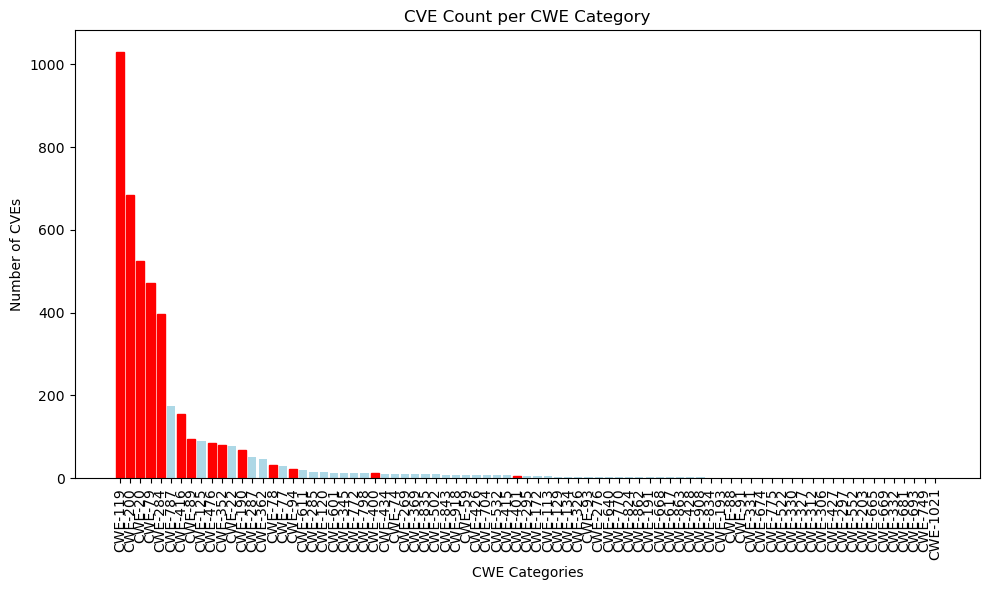

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


# Step 4: Count the CWEs in df (df2)
cwe_counts_df = df.groupby('cwe_id')['cve_count'].sum().reset_index()

# Step 5: Sort the CWEs by count for better visualization
cwe_counts_df = cwe_counts_df.sort_values(by='cve_count', ascending=False)

# Step 6: Create a bar plot for the CWEs in df
plt.figure(figsize=(10, 6))
bars = plt.bar(cwe_counts_df['cwe_id'], cwe_counts_df['cve_count'], color='lightblue')

# Step 7: Highlight the common CWEs in a different color (e.g., red)
for i, bar in enumerate(bars):
    if cwe_counts_df['cwe_id'].iloc[i] in common_cwes:
        bar.set_color('red')

# Step 8: Label the plot
plt.xlabel('CWE Categories')
plt.ylabel('Number of CVEs')
plt.title('CVE Count per CWE Category')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()

# Step 9: Display the plot
plt.show()

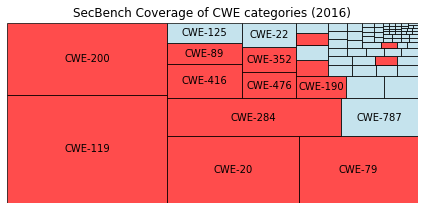

In [7]:
import squarify
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# cwe_counts_df['cwe_id'] = 'CWE-' + cwe_counts_df['cwe_id'].astype(str)

# Step 1: Sort CWEs by count
cwe_counts_df = cwe_counts_df.sort_values(by='cve_count', ascending=False)

# Step 2: Calculate the threshold for displaying text
total_area = sum(cwe_counts_df['cve_count'])
threshold = 0.012 * total_area  # Only show text for boxes greater than 2% of the total area

# Step 3: Create the treemap
plt.figure(figsize=(6, 3))  # Adjust the size to make it smaller

# Create the squares with a border and conditional text
squarify.plot(sizes=cwe_counts_df['cve_count'], 
              label=[str(label) if size > threshold else '' for label, size in zip(cwe_counts_df['cwe_id'], cwe_counts_df['cve_count'])],
              color=['red' if cwe in common_cwes else 'lightblue' for cwe in cwe_counts_df['cwe_id']],
              alpha=0.7, 
              edgecolor='black',  # Add black borders around the boxes
              linewidth=1)  # Set the border width

# Step 4: Hide the axes for a clean look
plt.axis('off')

# Step 5: Title and display the plot
plt.title('SecBench Coverage of CWE categories (2016)')
plt.tight_layout()  # Make the layout tight for better fitting

# Step 6: Display the plot
with PdfPages('Secbench2016.pdf') as pdf:
    pdf.savefig()
    # plt.close()
plt.savefig('secbench2016.png')
plt.show()

In [8]:
cwe_counts_df

,cwe_id,cve_count
2,CWE-119,1031
12,CWE-200,684
11,CWE-20,525
66,CWE-79,472
17,CWE-284,396
...,...,...
27,CWE-331,1
74,CWE-88,1
10,CWE-193,1
69,CWE-834,1


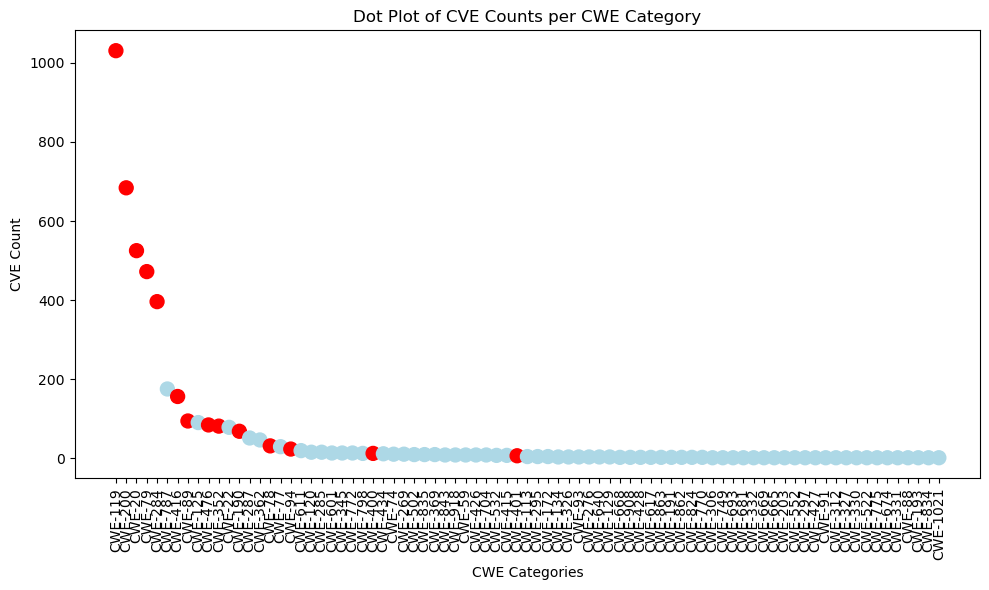

In [9]:
# Step 1: Plot dot plot
plt.figure(figsize=(10, 6))
plt.scatter(cwe_counts_df['cwe_id'], cwe_counts_df['cve_count'], 
            color=['red' if cwe in common_cwes else 'lightblue' for cwe in cwe_counts_df['cwe_id']], s=100)

# Step 2: Label the plot
plt.xlabel('CWE Categories')
plt.ylabel('CVE Count')
plt.title('Dot Plot of CVE Counts per CWE Category')
plt.xticks(rotation=90)
plt.tight_layout()

# Step 3: Display the plot
plt.show()